In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.3f}'.format)

sns.set_style('whitegrid')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams

In [3]:
interactions = pd.read_csv('data/train_cleaned_final.csv')
interactions.head()

,Unnamed: 0,Unnamed: 0.1,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,...,comp2_inv,comp3_rate,comp3_inv,comp5_rate,comp5_inv,comp8_rate,comp8_inv,click_bool,booking_bool,srch_hist_bool
0,0,0,1,2013-04-04 08:32:15,12,187,0.000,0.000,219,893,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0
1,1,1,1,2013-04-04 08:32:15,12,187,0.000,0.000,219,10404,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0,0,0
2,2,2,1,2013-04-04 08:32:15,12,187,0.000,0.000,219,21315,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0
3,3,3,1,2013-04-04 08:32:15,12,187,0.000,0.000,219,27348,...,0.000,-1.000,0.000,0.000,1.000,-1.000,0.000,0,0,0
4,4,4,1,2013-04-04 08:32:15,12,187,0.000,0.000,219,29604,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0


Some EDA

In [4]:
# Cardinality
n_users = interactions.srch_id.nunique()
n_items = interactions.prop_id.nunique()
n_interactions = len(interactions)

In [5]:
# Key User/Item Distributions
# number of items/orders by user
cnt_item_user = interactions.groupby('srch_id')['prop_id'].nunique()

# number of users/orders by item
cnt_user_item = interactions.groupby('prop_id')['srch_id'].nunique()

print(cnt_item_user.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]))
print(cnt_user_item.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]))

count   199776.000
mean        24.816
std          9.115
min          1.000
5%           7.000
10%          9.000
25%         18.000
50%         29.000
75%         32.000
90%         33.000
95%         34.000
max         38.000
Name: prop_id, dtype: float64
count   129111.000
mean        38.398
std         81.874
min          1.000
5%           1.000
10%          2.000
25%          4.000
50%         12.000
75%         40.000
90%         97.000
95%        156.000
max       2357.000
Name: srch_id, dtype: float64


s:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Number of Distinct Users/Item'),
 Text(0.5, 0, 'Number of Users'),
 Text(0, 0.5, 'Number of Items')]

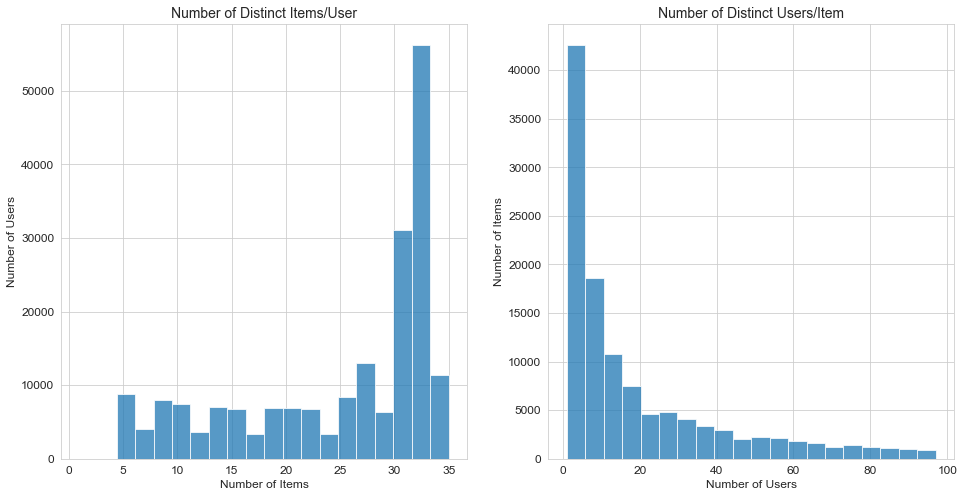

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes = axes.flatten()

range_0 = [1, cnt_item_user.quantile(0.99)]
range_1 = [1, cnt_user_item.quantile(0.90)]

sns_dist_params = dict(bins=20, hist=True, kde=False, rug=False)
sns.distplot(cnt_item_user,  **sns_dist_params, hist_kws={'range': range_0, 'alpha': 0.75}, ax=axes[0])
sns.distplot(cnt_user_item,  **sns_dist_params, hist_kws={'range': range_1, 'alpha': 0.75}, ax=axes[1])

axes[0].set(title="Number of Distinct Items/User", xlabel='Number of Items', ylabel='Number of Users')
axes[1].set(title="Number of Distinct Users/Item", xlabel='Number of Users', ylabel='Number of Items')

In [7]:
user_item_orders = interactions.groupby(['srch_id', 'prop_id']).size()
user_item_orders.head()

srch_id  prop_id
1        893        1
         10404      1
         21315      1
         27348      1
         29604      1
dtype: int64

In [8]:
most_popular_items = cnt_user_item.to_frame('cnt_users').reset_index().sort_values('cnt_users', ascending=False).reset_index(drop=True)
most_popular_items['pct_users'] = most_popular_items['cnt_users'] / n_users
most_popular_items.describe()

,prop_id,cnt_users,pct_users
count,129111.000,129111.000,129111.000
mean,70372.240,38.398,0.000
std,40669.932,81.874,0.000
min,1.000,1.000,0.000
25%,35141.500,4.000,0.000
50%,70335.000,12.000,0.000
75%,105594.500,40.000,0.000
max,140821.000,2357.000,0.012


In [9]:
print("users:", n_users)
print("items:", n_items)
print("interactions:", interactions.shape)
print("unique user/items pairs:", interactions[['srch_id', 'prop_id']].drop_duplicates().shape[0])

users: 199776
items: 129111
interactions: (4957546, 39)
unique user/items pairs: 4957546


In [10]:
# Evaluate User/Item Interaction Sparsity
print('---Evaluate User/Item Interaction Sparsity---')
sparsity = 1 - (interactions[['srch_id', 'prop_id']].drop_duplicates().shape[0] / (n_users * n_items))
print("full interaction data sparsity: {}".format(round(100 * sparsity, 2)))

---Evaluate User/Item Interaction Sparsity---
full interaction data sparsity: 99.98


In [11]:
mask = interactions.click_bool != 0
click_interactions = interactions[mask]
print("click users:", len(click_interactions.srch_id.unique()))
print("clicked items:", len(click_interactions.prop_id.unique()))
print("click interactions:", click_interactions.shape)

click users: 199759
clicked items: 57859
click interactions: (221835, 39)


In [12]:
mask = interactions.booking_bool != 0
book_interactions = interactions[mask]
print("book users:", len(book_interactions.srch_id.unique()))
print("booked items:", len(book_interactions.prop_id.unique()))
print("book interactions:", book_interactions.shape)

book users: 138361
booked items: 43422
book interactions: (138361, 39)


Subsample the Data for Initial Testing

In [13]:
# Take a Random Subsample of Users
all_users = interactions.srch_id.unique()
all_items = interactions.prop_id.unique()

# np.random.seed(1492)
# sample_users = np.random.choice(all_users, size=10000, replace=False)
sample_users = all_users

# Get All Interactions for Those Users
# sample_interactions = interactions[interactions.srch_id.isin(sample_users)].copy()
sample_interactions = click_interactions
print(f'shape of sample interactions {sample_interactions.shape}')

sample_items = sample_interactions.prop_id.unique()
print(f'len of sample items {len(sample_items)}')
print()
print('---Re-Evaluate Cardinality/Sparsity on the Sample---')

n_s_users = len(sample_users)
n_s_items = len(sample_items)

print("sample users:", n_s_users)
print("sample items:", n_s_items)
print("sample interactions:", sample_interactions.shape)

sample_sparsity = 1 - (sample_interactions[['srch_id', 'prop_id']].drop_duplicates().shape[0] / (n_s_users * n_s_items))
print("sample interaction data sparsity: {}".format(round(100 * sample_sparsity, 2)))

shape of sample interactions (221835, 39)
len of sample items 57859

---Re-Evaluate Cardinality/Sparsity on the Sample---
sample users: 199776
sample items: 57859
sample interactions: (221835, 39)
sample interaction data sparsity: 100.0


Split the Data into Training/Validation Sets

In [14]:
# Randomly Shuffle the Overall Interaction Data
shuffle_index = np.arange(len(sample_interactions))
np.random.shuffle(shuffle_index)

sample_interactions = sample_interactions.iloc[shuffle_index].iloc[:,1:]
sample_interactions['random'] = np.random.random(size=len(sample_interactions))
sample_interactions.head()

,Unnamed: 0.1,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,...,comp3_rate,comp3_inv,comp5_rate,comp5_inv,comp8_rate,comp8_inv,click_bool,booking_bool,srch_hist_bool,random
3988895,3989566,267735,2013-04-10 21:36:27,12,99,0.000,0.000,99,92400,3,...,0.000,0.000,-1.000,0.000,0.000,0.000,1,0,0,0.128
2511635,2512024,168660,2012-11-26 18:26:11,5,219,0.000,0.000,219,116537,3,...,0.000,0.000,0.000,0.000,0.000,0.000,1,0,0,0.280
437013,437096,29282,2013-01-16 16:06:53,5,219,0.000,0.000,219,81385,4,...,0.000,0.000,0.000,0.000,0.000,0.000,1,0,0,0.872
1852682,1852950,124416,2013-06-26 18:18:03,14,100,0.000,0.000,100,58948,3,...,0.000,0.000,0.000,0.000,0.000,0.000,1,1,0,0.419
4267364,4268081,286501,2013-05-22 13:22:16,5,219,0.000,0.000,219,14857,3,...,0.000,0.000,0.000,0.000,0.000,0.000,1,1,0,0.857


In [71]:
# Split Off 25% to Use for Validation
test_pct = 0.25
train_mask = sample_interactions['random'] <  (1 - test_pct)
train_mask = sample_interactions['random'] < 1
valid_mask = sample_interactions['random'] >= (1 - test_pct)
          
interactions_total = sample_interactions[['srch_id', 'prop_id']]
interactions_total = interactions_total.iloc[shuffle_index]

interactions_train = sample_interactions[train_mask].groupby(['srch_id', 'prop_id']).size().to_frame('orders').reset_index()
interactions_valid = sample_interactions[valid_mask].groupby(['srch_id', 'prop_id']).size().to_frame('orders').reset_index()

# sample_weight_train = np.log2(interactions_train['orders'] + 1)
# sample_weight_valid = np.log2(interactions_valid['orders'] + 1)

interactions_train = interactions_train[['srch_id', 'prop_id']]
interactions_valid = interactions_valid[['srch_id', 'prop_id']]


train_users = np.sort(interactions_train.srch_id.unique())
valid_users = np.sort(interactions_valid.srch_id.unique())
cold_start_users = set(valid_users) - set(train_users)

train_items = np.sort(interactions_train.prop_id.unique())
valid_items = np.sort(interactions_valid.prop_id.unique())
cold_start_items = set(valid_items) - set(train_items)

print("total shape: {}".format(interactions_total.shape))
print("train shape: {}".format(interactions_train.shape))
print("valid shape: {}".format(interactions_valid.shape))

# print("\ntrain weights shape: {}".format(sample_weight_train.shape))
# print("valid weights shape: {}".format(sample_weight_valid.shape))

print("\ntrain users: {}".format(len(train_users)))
print("valid users: {}".format(len(valid_users)))
print("cold-start users: {}".format(cold_start_users))

print("\ntrain items: {}".format(len(train_items)))
print("valid items: {}".format(len(valid_items)))
print("number of cold-start items: {}".format(len(cold_start_items)))

total shape: (221835, 2)
train shape: (221835, 2)
valid shape: (55533, 2)

train users: 199759
valid users: 53390
cold-start users: set()

train items: 57859
valid items: 28416
number of cold-start items: 0


In [16]:
len(cold_start_users) == 0

True

Model

In [17]:
# Specify Number of Recommended Items
k = 10

In [18]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
# create zero-based index position to identifier mappings
index_to_user = pd.Series(np.sort(np.unique(interactions_train['srch_id'])))
index_to_item = pd.Series(np.sort(np.unique(interactions_train['prop_id'])))

# create reverse mappings from identifiers to zero-based index positions
user_to_index = pd.Series(data=index_to_user.index, index=index_to_user.values)
item_to_index = pd.Series(data=index_to_item.index, index=index_to_item.values)

interactions_train_imp = interactions_train.copy()
interactions_train_imp['srch_id'] = interactions_train['srch_id'].map(user_to_index)
interactions_train_imp['prop_id'] = interactions_train['prop_id'].map(item_to_index)

n_users_train = len(index_to_user)
n_items_train = len(index_to_item)
n_inter_train = len(interactions_train_imp)
print(n_users_train, n_items_train, n_inter_train)

data = np.ones(n_inter_train)
rows = interactions_train_imp['srch_id']
cols = interactions_train_imp['prop_id']

user_items_imp = csr_matrix((data, (rows, cols)), shape=(n_users_train, n_items_train))
item_users_imp = user_items_imp.T.tocsr()
user_items_imp, item_users_imp

199759 57859 221835


(<199759x57859 sparse matrix of type '<class 'numpy.float64'>'
 	with 221835 stored elements in Compressed Sparse Row format>,
 <57859x199759 sparse matrix of type '<class 'numpy.float64'>'
 	with 221835 stored elements in Compressed Sparse Row format>)

In [25]:
%%time
# Fit the Model
imp_model = AlternatingLeastSquares(factors=64, regularization=0.05, use_native=True, use_cg=False)

imp_model.fit(user_items_imp, show_progress=True)

100%|██████████| 15/15 [00:15<00:00,  1.01s/it]

Wall time: 16.2 s


In [36]:
index_to_user.index.to_numpy()

array([     0,      1,      2, ..., 199756, 199757, 199758], dtype=int64)

In [38]:
result = imp_model.recommend(user_items=user_items_imp, userid=index_to_user.index.to_numpy(), N=100)

In [75]:
list(result)[1]

array([[2.9515763e-04, 5.2584575e-05, 4.9180959e-05, ..., 5.6749673e-07,
        5.5009508e-07, 5.4913369e-07],
       [1.8232161e-12, 1.2422802e-12, 9.3381639e-13, ..., 4.0415035e-14,
        3.9706275e-14, 3.9476980e-14],
       [2.3631210e-27, 2.2190757e-27, 1.5955007e-27, ..., 6.6083832e-29,
        6.6060480e-29, 6.3652731e-29],
       ...,
       [2.1736271e-21, 2.0759107e-21, 1.9028739e-21, ..., 5.6976596e-23,
        5.5937609e-23, 5.5517134e-23],
       [4.2150045e-06, 3.9207548e-06, 3.5541284e-06, ..., 9.0759052e-08,
        8.7165986e-08, 8.5667018e-08],
       [4.7105682e-19, 4.2346377e-19, 3.6602561e-19, ..., 7.6714798e-21,
        7.6041752e-21, 7.5017309e-21]], dtype=float32)

In [88]:
df_fmresult = pd.DataFrame(list(result)[0], index=index_to_user.values).apply(lambda c: c.map(index_to_item)).stack().reset_index()
df_fmresult.columns = ['srch_id', 'fm_rank', 'prop_id']
df_fmresult['fm_score'] = list(result)[1].reshape(-1)
sum_fm = df_fmresult.groupby('srch_id')['fm_score'].agg('sum').to_frame('score_mean')
df_fmresult['fm_rank'] = 100 - df_fmresult['fm_rank']
df_fmresult = df_fmresult.join(sum_fm, on='srch_id')
df_fmresult.fm_score /= ((df_fmresult.score_mean + 0.001)/100)
df_fmresult.to_csv('data/fm_rank.csv')

In [89]:
df_fmresult

,srch_id,fm_rank,prop_id,fm_score,score_mean
0,1,100,53341,15.618,0.001
1,1,99,88096,2.782,0.001
2,1,98,88218,2.602,0.001
3,1,97,65606,2.069,0.001
4,1,96,30184,2.050,0.001
...,...,...,...,...,...
19975895,332785,5,120144,0.000,0.000
19975896,332785,4,34852,0.000,0.000
19975897,332785,3,108251,0.000,0.000
19975898,332785,2,140582,0.000,0.000


In [30]:
user_items_imp.shape[0]

199759

In [26]:
# Generate TopN Recommendations for Each User
recs_imp = imp_model.recommend_all(user_items=user_items_imp, N=k)
# recs_imp = pd.DataFrame(recs_imp, index=index_to_user.values).apply(lambda c: c.map(index_to_item))
# recs_imp = recs_imp.loc[valid_users]
# recs_imp.head()

In [27]:
recs_imp

array([[21967, 36217, 36275, ..., 30638, 46652, 15863],
       [20917, 22553, 33104, ..., 14498, 37369, 54566],
       [54566, 54240, 48945, ...,  5705, 55698, 14688],
       ...,
       [37369, 10162,  5705, ..., 24644, 16665,  1284],
       [48945, 20917,  6609, ...,  7614, 10162,  7308],
       [54240, 33104, 43393, ..., 21878, 39653, 14688]])

In [195]:
print(recs_imp.shape)
print(np.array_equal(recs_imp.index, valid_users))

(53472, 10)
True


In [197]:
# Evaluate Implicit's Performance on Hold-Out Data
valid_user_items = interactions_valid.groupby('srch_id')['prop_id'].apply(set).to_dict()
imp_hrt = np.mean([int(len(set(recs_imp.loc[u]) & valid_user_items[u]) > 0) for u in valid_users])
imp_pre = np.mean([len(set(recs_imp.loc[u]) & valid_user_items[u]) / len(recs_imp.loc[u]) for u in valid_users])
imp_rec = np.mean([len(set(recs_imp.loc[u]) & valid_user_items[u]) / len(valid_user_items[u]) for u in valid_users])

print("hit_rate: {:.3f}".format(imp_hrt))
print("precision: {:.3f}".format(imp_pre))
print("recall: {:.3f}".format(imp_rec))

hit_rate: 0.000
precision: 0.000
recall: 0.000
